### 2.1 Return Series Pure Python

In [1]:
from typing import List

In [2]:
def calculate_return_series(prices: List[float]) -> List[float]:
    """
    Calculates return series as a parallel list of returns on prices
    """
    return_series = [None]
    for i in range(1, len(prices)):
        return_series.append((prices[i] / prices[i-1]) - 1)

    return return_series

### 2.2 Return Series Pandas

In [3]:
import pandas as pd

In [4]:
def calculate_return_series(series: pd.Series) -> pd.Series:
    """
    Calculates the return series of a time series.
    The first value will always be NaN.
    Output series retains the index of the input series.
    """
    shifted_series = series.shift(1, axis=0)
    return series / shifted_series - 1

### 2.3 Log Return Series

In [5]:
import numpy as np

In [6]:
def calculate_log_return_series(series: pd.Series) -> pd.Series:
    """
    Same as calculate_return_series but with log returns
    """
    shifted_series = series.shift(1, axis=0)
    return pd.Series(np.log(series / shifted_series))

### 2.4 Annualized Volatility

$$
Annualized\;Volatility=\sigma * \sqrt{Number\;of\;Periods}
$$

In [7]:
def get_years_past(series: pd.Series) -> float:
    """
    Calculate the years past according to the index of the series for use with
    functions that require annualization   
    """
    start_date = series.index[0]
    end_date = series.index[-1]
    return (end_date - start_date).days / 365.25

In [8]:
def calculate_annualized_volatility(return_series: pd.Series) -> float:
    """
    Calculates annualized volatility for a date-indexed return series. 
    Works for any interval of date-indexed prices and returns.
    """
    years_past = get_years_past(return_series)
    entries_per_year = return_series.shape[0] / years_past
    return return_series.std() * np.sqrt(entries_per_year)

### 2.5 Annualized Volatility on AWU

In [9]:
# load path
import sys
if "../src/" not in sys.path:
    sys.path.append("../src/")

from pypm import data_io, metrics

In [10]:
df = data_io.load_eod_data('AWU')
df

,open,close,low,high,volume
date,,,,,
2010-01-04,193.94,191.70,190.63,195.51,968029
2010-01-05,191.02,188.17,186.99,192.42,1427075
2010-01-06,187.17,186.50,185.10,190.07,879014
2010-01-07,185.03,185.19,183.63,186.64,1003719
2010-01-08,184.67,187.02,182.78,187.27,804716
...,...,...,...,...,...
2019-12-24,331.06,330.85,328.43,332.91,98751
2019-12-26,331.36,329.05,327.47,333.05,209398
2019-12-27,332.47,325.38,325.16,332.47,225667


<Axes: xlabel='date'>

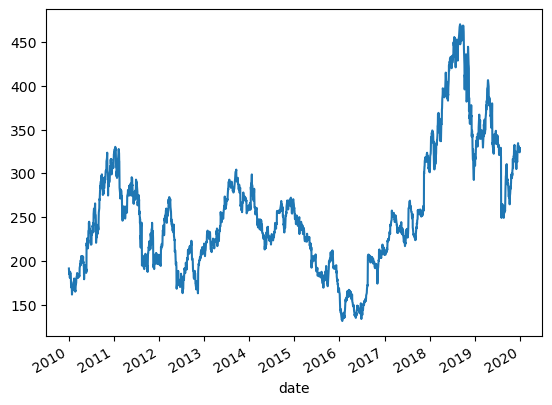

In [11]:
df['close'].plot()

In [12]:
return_series = metrics.calculate_log_return_series(df['close'])
metrics.calculate_annualized_volatility(return_series)

0.3296226627596169

### 2.6 Calculating CAGR

$$
CAGR(\%) = \frac{Ending\;Value}{Beginning\;Value} ^ \frac{1}{Number\;of\;Periods} – 1
$$

In [13]:
def calculate_cagr(series: pd.Series) -> float:
    """
    Calculate compounded annual growth rate
    """
    value_factor = series.iloc[-1] / series.iloc[0]
    year_past = get_years_past(series)
    return (value_factor ** (1 / year_past)) - 1

### 2.7 Calculating CAGR on AWU

In [14]:
df = data_io.load_eod_data('AWU')
metrics.calculate_cagr(df['close'])

0.055545750640820346

### 2.8 Calculating Sharpe Ratio

In [15]:
def calculate_sharpe_ratio(price_series: pd.Series, 
    benchmark_rate: float=0) -> float:
    """
    Calculates the sharpe ratio given a price series. Defaults to benchmark_rate
    of zero.
    """
    cagr = calculate_cagr(price_series)
    return_series = calculate_return_series(price_series)
    volatility = calculate_annualized_volatility(return_series)
    return (cagr - benchmark_rate) / volatility

### 2.9 Calculating Downside Volatility

In [16]:
def calculate_annualized_downside_deviation(return_series: pd.Series, 
    benchmark_rate: float=0) -> float:
    """
    Calculates the downside deviation for use in the sortino ratio.

    Benchmark rate is assumed to be annualized. It will be adjusted according 
    to the number of periods per year seen in the data.
    """

    # For both de-annualizing the benchmark rate and annualizing result
    years_past = get_years_past(return_series)
    entries_per_year = return_series.shape[0] / years_past

    adjusted_benchmark_rate = ((1+benchmark_rate) ** (1/entries_per_year)) - 1

    downside_series = adjusted_benchmark_rate - return_series
    downside_sum_of_squares = (downside_series[downside_series > 0] ** 2).sum()
    denominator = return_series.shape[0] - 1
    downside_deviation = np.sqrt(downside_sum_of_squares / denominator)

    return downside_deviation * np.sqrt(entries_per_year)

In [17]:
def calculate_sortino_ratio(price_series: pd.Series, 
    benchmark_rate: float=0) -> float:
    """
    Calculates the sortino ratio.
    """
    cagr = calculate_cagr(price_series)
    return_series = calculate_return_series(price_series)
    downside_deviation = calculate_annualized_downside_deviation(return_series)
    return (cagr - benchmark_rate) / downside_deviation

### 2.10 Maximum Drawdown

In [18]:
from typing import Dict, Any, Callable

In [19]:
DRAWDOWN_EVALUATORS: Dict[str, Callable] = {
    'dollar': lambda price, peak: peak - price,
    'percent': lambda price, peak: -((price / peak) - 1),
    'log': lambda price, peak: np.log(peak) - np.log(price),
}

In [20]:
def calculate_drawdown_series(series: pd.Series, method: str='log') -> pd.Series:
    """
    Returns the drawdown series
    """
    assert method in DRAWDOWN_EVALUATORS, \
        f'Method "{method}" must by one of {list(DRAWDOWN_EVALUATORS.keys())}'

    evaluator = DRAWDOWN_EVALUATORS[method]
    return evaluator(series, series.cummax())

In [21]:
def calculate_max_drawdown(series: pd.Series, method: str='log') -> float:
    """
    Simply returns the max drawdown as a float
    """
    return calculate_drawdown_series(series, method).max()

### 2.11 Maximum Drawdown with Metadata

In [22]:
def calculate_max_drawdown_with_metadata(series: pd.Series, 
    method: str='log') -> Dict[str, Any]:
    """
    Calculates max_drawdown and stores metadata about when and where. Returns 
    a dictionary of the form 
        {
            'max_drawdown': float,
            'peak_date': pd.Timestamp,
            'peak_price': float,
            'trough_date': pd.Timestamp,
            'trough_price': float,
        }
    """

    assert method in DRAWDOWN_EVALUATORS, \
        f'Method "{method}" must by one of {list(DRAWDOWN_EVALUATORS.keys())}'

    evaluator = DRAWDOWN_EVALUATORS[method]

    max_drawdown = 0
    local_peak_date = peak_date = trough_date = series.index[0]
    local_peak_price = peak_price = trough_price = series.iloc[0]

    for date, price in series.iteritems():

        # Keep track of the rolling max
        if price > local_peak_price:
            local_peak_date = date
            local_peak_price = price

        # Compute the drawdown
        drawdown = evaluator(price, local_peak_price)

        # Store new max drawdown values
        if drawdown > max_drawdown:
            max_drawdown = drawdown

            peak_date = local_peak_date
            peak_price = local_peak_price

            trough_date = date
            trough_price = price

    return {
        'max_drawdown': max_drawdown,
        'peak_date': peak_date,
        'peak_price': peak_price,
        'trough_date': trough_date,
        'trough_price': trough_price
    }

### 2.12 Log Max Drawdown Ratio

In [23]:
def calculate_log_max_drawdown_ratio(series: pd.Series) -> float:
    log_drawdown = calculate_max_drawdown(series, method='log')
    log_return = np.log(series.iloc[-1]) - np.log(series.iloc[0])
    return log_return - log_drawdown

### 2.13 Calmar Ratio

$$
Calmar\;Ratio = \frac{Average\;Annual\;Rate\;of\;Return}{Maximum\;Drawdown}
$$

In [24]:
def calculate_calmar_ratio(series: pd.Series, years_past: int=3) -> float:
    """
    Return the percent max drawdown ratio over the past three years using
    CAGR as the numerator, otherwise known as the Calmar Ratio
    """

    # Filter series on past three years
    last_date = series.index[-1]
    three_years_ago = last_date - pd.Timedelta(days=years_past*365.25)
    series = series[series.index > three_years_ago]

    # Compute annualized percent max drawdown ratio
    percent_drawdown = calculate_max_drawdown(series, method='percent')
    cagr = calculate_cagr(series)
    return cagr / percent_drawdown

### 2.14 Pure Profit Score

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
def calculate_pure_profit_score(price_series: pd.Series) -> float:
    """
    Calculates the pure profit score
    """
    cagr = calculate_cagr(price_series)

    # Build a single column for a predictor, t
    t: np.ndarray = np.arange(0, price_series.shape[0]).reshape(-1, 1)

    # Fit the regression
    regression = LinearRegression().fit(t, price_series)

    # Get the r-squared value
    r_squared = regression.score(t, price_series)

    return cagr * r_squared

### 2.15 Jensens Alpha

In [27]:
def calculate_jensens_alpha(return_series: pd.Series, 
    benchmark_return_series: pd.Series) -> float: 
    """
    Calculates jensens alpha. Prefers input series have the same index. Handles
    NAs.
    """

    # Join series along date index and purge NAs
    df = pd.concat([return_series, benchmark_return_series], sort=True, axis=1)
    df = df.dropna()

    # Get the appropriate data structure for scikit learn
    clean_returns: pd.Series = df[return_series.name]
    clean_benchmarks = pd.DataFrame(df[benchmark_return_series.name])

    # Fit a linear regression and return the alpha
    regression = LinearRegression().fit(clean_benchmarks, y=clean_returns)
    return regression.intercept_